In [1]:
import torch
import torch.nn as nn
# noinspection PyUnresolvedReferences
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
imsize = 512

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("Old/assets/style_images/starry.jpg")
content_img = image_loader("data/images/eiffel.jpeg")

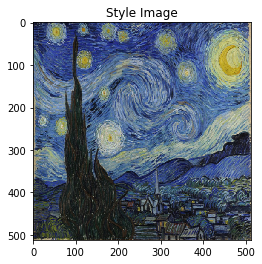

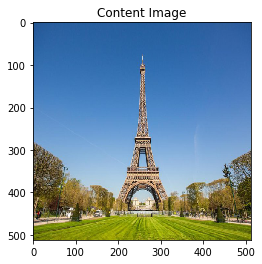

In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()  # Interactive mode


def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def imsave(tensor, title="gen/pic.jpeg"):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    image = image.save(title)
    
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = None
        
    # noinspection PyShadowingBuiltins
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [6]:
# noinspection PyShadowingBuiltins
def gram_matrix(input):
    batch_dim, channels, rows, columns = input.size() 
    features = input.view(batch_dim * channels, rows * columns)
    gram_product = torch.mm(features, features.t())
    return gram_product.div(batch_dim * channels * rows * columns)

In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.gram_product_target = gram_matrix(target_feature).detach()
        self.loss = None

    # noinspection PyShadowingBuiltins
    def forward(self, input):
        gram_product_feature = gram_matrix(input)
        self.loss = F.mse_loss(gram_product_feature, self.gram_product_target)
        return input

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [10]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# noinspection PyShadowingNames
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

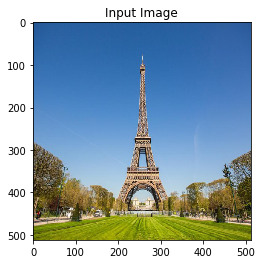

In [11]:
input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [12]:
# noinspection PyShadowingNames
def get_input_optimizer(input_img):
    # noinspection PyUnresolvedReferences
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


In [13]:
# noinspection PyShadowingNames
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    
    model, style_losses, content_losses = \
        get_style_model_and_losses(cnn,
                                   normalization_mean, normalization_std, style_img,
                                   content_img)
    
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run}:")
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                
                print()
                imsave(input_img, f'data/gen/run_{run}.jpeg')
                

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 53.840675 Content Loss: 18.487728

run [100]:
Style Loss : 15.836926 Content Loss: 18.254660

run [150]:
Style Loss : 8.423142 Content Loss: 15.723583

run [200]:
Style Loss : 5.423975 Content Loss: 13.824178

run [250]:
Style Loss : 3.667426 Content Loss: 12.609408

run [300]:
Style Loss : 2.675009 Content Loss: 11.872249

run [350]:
Style Loss : 1.988413 Content Loss: 11.376733

run [400]:
Style Loss : 1.576361 Content Loss: 11.063588

run [450]:
Style Loss : 1.399867 Content Loss: 10.827181

run [500]:
Style Loss : 1.149107 Content Loss: 10.659288

run [550]:
Style Loss : 1.073968 Content Loss: 10.499126

run [600]:
Style Loss : 1.005745 Content Loss: 10.411479

run [650]:
Style Loss : 0.967396 Content Loss: 10.313856

run [700]:
Style Loss : 0.951036 Content Loss: 10.300235

run [750]:
Style Loss : 0.937958 Content Loss: 10.185065

run [800]:
Style Loss : 39207724.000000 Content Loss: 588.037964

run [850]:
Sty

/home/syzygianinfern0/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/syzygianinfern0/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


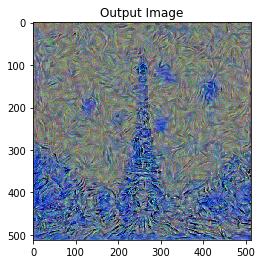

In [14]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 5000)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()